# Import Library

In [8]:
# unix time: https://www.unixtimestamp.com/
import datetime  # Convert to unix time
import math
import os
import pickle
import time  # Convert to unix time
import warnings

import dask.dataframe as dd  # similar to pandas
import matplotlib.pylab as plt
# if numpy is not installed already : pip3 install numpy
import numpy as np  # Do aritmetic operations on arrays
import pandas as pd  # pandas to create small dataframes
import seaborn as sns  # Plots

warnings.filterwarnings("ignore")

# Data Load

In [9]:
base_year = 2018
base_month_count = 12

In [10]:
df = pd.read_parquet(f'yellow_tripdata_{base_year}-01.parquet', engine='pyarrow') 
taxi_zone_df = pd.read_csv('taxi_zone_lookup.csv')

## Select Region

In [11]:
region = "Manhattan"

In [12]:
nyc_region = taxi_zone_df[taxi_zone_df['Borough'] == region]
nyc_region_number = nyc_region['LocationID']

In [13]:
nyc_regions_cnt = len(nyc_region)
print(nyc_regions_cnt)

69


In [14]:
nyc_region_arr_data = []
for i in nyc_region_number.values:
    nyc_region_arr_data.append(df[df['PULocationID'] == i])

In [15]:
nyc_region_df = pd.concat(nyc_region_arr_data, axis=0, ignore_index=True)

## Convert Trip Duration

In [16]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    s = np.datetime_as_string(s, unit='s')
    s = s.replace('T', ' ')
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())




# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']]
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','PULocationID','DOLocationID','total_amount', 'tip_amount']]
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(nyc_region_df)
print(frame_with_durations.head())

   passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0                4            0.7             4           232          6.30   
1                1            0.8             4           148          9.55   
2                2            1.1             4           224          7.30   
3                1            0.9             4           232          7.80   
4                1            2.9             4            68         15.80   

   tip_amount  trip_times  pickup_times      Speed  
0        0.00    4.716667  1.514733e+09   8.904594  
1        1.25    8.566667  1.514735e+09   5.603113  
2        0.00    5.716667  1.514736e+09  11.545190  
3        0.00    7.700000  1.514734e+09   7.012987  
4        0.00   20.283333  1.514734e+09   8.578472  


## Trip Durations

In [17]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -5711.583333333333
10 percentile value is 3.85
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.933333333333334
60 percentile value is 11.833333333333334
70 percentile value is 14.183333333333334
80 percentile value is 17.416666666666668
90 percentile value is 22.8
100 percentile value is  1439.9833333333333


In [18]:
# 99 percentile value
trip_times_diffusion = var[int(len(var)*(float(99)/100))]

for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    tmp = var[int(len(var)*(float(99+i)/100))]
    if trip_times_diffusion * 10 < tmp:
        trip_times_diffusion = var[int(len(var)*(float(99+i-0.1)/100))] * 2
        print(f"{99+i} percentile is diffusion value. So we set outline value {99+i-0.1} percentile value X 2: {trip_times_diffusion}")
        break
    print("{} percentile value is {}".format(99+i,tmp))
print("100 percentile value is ",var[-1])

99.0 percentile value is 43.81666666666667
99.1 percentile value is 45.2
99.2 percentile value is 46.86666666666667
99.3 percentile value is 48.93333333333333
99.4 percentile value is 51.516666666666666
99.5 percentile value is 54.95
99.6 percentile value is 60.03333333333333
99.7 percentile value is 68.0
99.8 percentile value is 90.38333333333334
99.9 percentile is diffusion value. So we set outline value 99.80000000000001 percentile value X 2: 180.76666666666668
100 percentile value is  1439.9833333333333


In [19]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<trip_times_diffusion)]

## Speed

In [20]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    if i == 0.9:
        speed_99_9 = var[int(len(var)*(float(99+i)/100))]
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 29.027303754266207
99.1 percentile value is 29.577464788732396
99.2 percentile value is 30.187110187110182
99.3 percentile value is 30.874715261958997
99.4 percentile value is 31.656370656370655
99.5 percentile value is 32.54237288135593
99.6 percentile value is 33.607250755287005
99.7 percentile value is 34.95603367633302
99.8 percentile value is 36.747252747252745
99.9 percentile value is 39.55748031496063
100 percentile value is  9774.117647058823


In [21]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<=speed_99_9)]

In [22]:
#avg.speed of cabs in New-York
avg_speed = sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))
avg_speed

10.69346116566279

## Trip Distance

In [23]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    if i ==0.9:
        trip_distance_99_9 = var[int(len(var)*(float(99+i)/100))]
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 13.8
99.1 percentile value is 14.85
99.2 percentile value is 15.9
99.3 percentile value is 16.5
99.4 percentile value is 16.93
99.5 percentile value is 17.3
99.6 percentile value is 17.7
99.7 percentile value is 18.3
99.8 percentile value is 19.29
99.9 percentile value is 20.7
100 percentile value is  98.7


In [24]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<=trip_distance_99_9)]

## Total Fare

In [25]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 54.56
99.1 percentile value is 57.8
99.2 percentile value is 58.56
99.3 percentile value is 62.06
99.4 percentile value is 63.56
99.5 percentile value is 68.56
99.6 percentile value is 70.27
99.7 percentile value is 71.17
99.8 percentile value is 75.8
99.9 percentile value is 90.8
100 percentile value is  1017.3


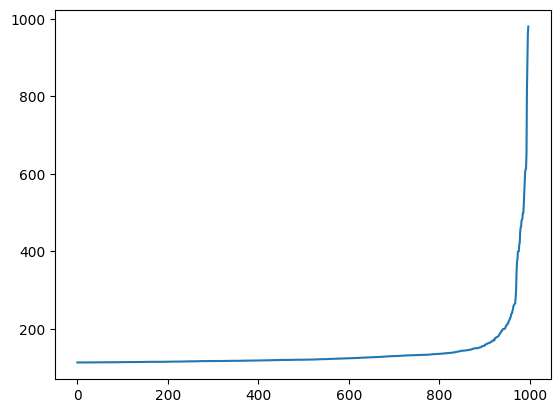

In [26]:
# we plot last 50 values excluding last two values
plt.plot(var[-1000:-2])
plt.show()

In [27]:
total_amount_diffusion = 300

## 2-5. Tip Amount

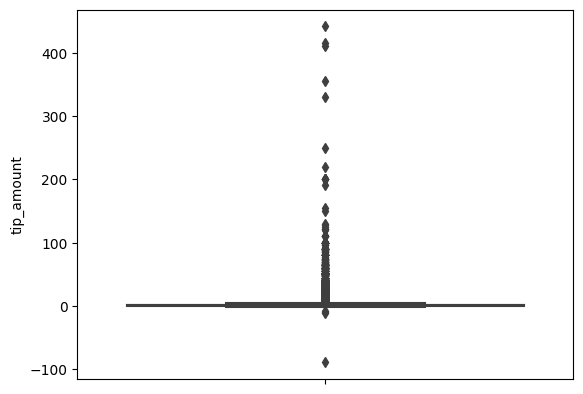

In [28]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="tip_amount", data =frame_with_durations_modified)
plt.show()

In [29]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["tip_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -88.8
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 1.0
50 percentile value is 1.36
60 percentile value is 1.7
70 percentile value is 2.0
80 percentile value is 2.49
90 percentile value is 3.36
100 percentile value is  441.71


In [30]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["tip_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 3.36
91 percentile value is 3.55
92 percentile value is 3.75
93 percentile value is 3.96
94 percentile value is 4.16
95 percentile value is 4.46
96 percentile value is 4.96
97 percentile value is 5.35
98 percentile value is 6.36
99 percentile value is 8.5
100 percentile value is  441.71


In [31]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["tip_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 8.5
99.1 percentile value is 8.91
99.2 percentile value is 9.46
99.3 percentile value is 10.0
99.4 percentile value is 10.4
99.5 percentile value is 11.04
99.6 percentile value is 11.71
99.7 percentile value is 12.0
99.8 percentile value is 13.89
99.9 percentile value is 15.95
100 percentile value is  441.71


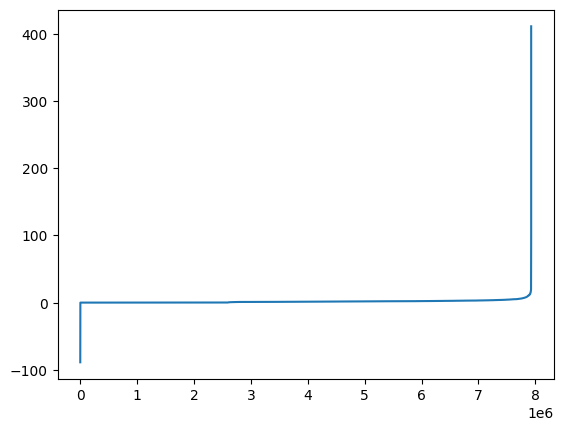

In [32]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

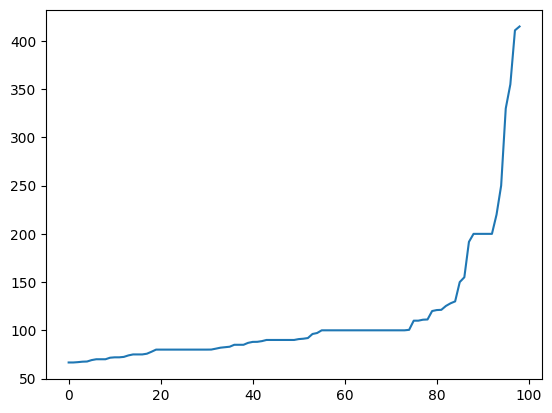

In [33]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[-100:-1])
plt.show()

In [34]:
tip_amount_diffusion = 15

## Remove all outliers/erronous points

In [35]:
def map_region(dataframe, region):
    region_df = taxi_zone_df[taxi_zone_df['Borough'] == region]
    region_number = region_df['LocationID']
    
    region_arr_data = []
    for i in region_number.values:
        region_arr_data.append(dataframe[dataframe['PULocationID'] == i])
    
    region_df = pd.concat(region_arr_data, axis=0, ignore_index=True)

    return region_df
    

In [36]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    # a = new_frame.shape[0]
    # print ("Number of pickup records = ",a)
    
    # temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    # c = temp_frame.shape[0]
    # print ("Number of outliers from trip times analysis:",(a-c))
    
    
    # temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 25.52)]
    # d = temp_frame.shape[0]
    # print ("Number of outliers from trip distance analysis:",(a-d))
    
    # temp_frame = new_frame[(new_frame.Speed <= 45.28) & (new_frame.Speed >= 0)]
    # e = temp_frame.shape[0]
    # print ("Number of outliers from speed analysis:",(a-e))
    
    # temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    # f = temp_frame.shape[0]
    # print ("Number of outliers from fare analysis:",(a-f))
    
    new_frame = new_frame[(new_frame.total_amount > 0) & (new_frame.total_amount <total_amount_diffusion)]
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < trip_times_diffusion)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance <= trip_distance_99_9)]
    new_frame = new_frame[(new_frame.Speed > 0) & (new_frame.Speed <= speed_99_9)]
    new_frame = new_frame[(new_frame.tip_amount >= 0) & (new_frame.tip_amount <= tip_amount_diffusion)]

    
    
    # print ("Total outliers removed",a - new_frame.shape[0])
    # print ("---")
    return new_frame

### unixtimestamp

In [37]:
def set_unixtimestamp():
    unix_times = []
    for year in range(2):
        tmp = []
        for i in range(1,base_month_count+1):
            date_time = datetime.datetime(base_year+year, i, 1, 0, 0)
            tmp.append(int(time.mktime(date_time.timetuple())))
        unix_times.append(tmp)
    return unix_times

In [38]:
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]

    unix_times = set_unixtimestamp()
    
    start_pickup_unix=unix_times[year-base_year][month-1]

    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [39]:
def datapreparation(month,month_no,year_no):
    
    print(f"start {month_no} month ..")

    print ("Return with trip times..")
    new_frame = map_region(month, region)

    frame_with_durations = return_with_trip_times(new_frame)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['PULocationID','pickup_bins','trip_distance']].groupby(['PULocationID','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame

read_months = []
for i in range(1,base_month_count+1):
    if i < 10:
        read_months.append(pd.read_parquet(f'yellow_tripdata_{base_year+1}-0{i}.parquet',engine='pyarrow'))
    else:
        read_months.append(pd.read_parquet(f'yellow_tripdata_{base_year+1}-{i}.parquet',engine='pyarrow'))


months_frame = []
months_groupby = []
for index, month in enumerate(read_months):
    tmp_frame, tmp_groupby = datapreparation(month, index+1,base_year+1)

    preprocesingFile = f'preprocessing_yellow_tripdata_{base_year+1}_{index+1}.parquet'
    tmp_frame.to_parquet(preprocesingFile)

    months_frame.append(tmp_frame)
    months_groupby.append(tmp_groupby)

start 12 month ..
Return with trip times..
Remove outliers..
Final groupbying..
